The whole synobsis for custom datasets is *How do you get your own data into PyTorch?*

## Importing PyTorch and setting up device agnostic code

In [1]:
import torch
from torch import nn

torch.__version__

'1.13.1+cu116'

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [3]:
!nvidia-smi

Wed Feb  1 09:39:44 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.47.03    Driver Version: 510.47.03    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   66C    P0    30W /  70W |      3MiB / 15360MiB |      5%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Getting data

When starting out ML projects, it's important to try things on a small scale and then increase the scale when necessary. The whole point is to speed up how fast you can experiment.

Our dataset starts with 3 classess of food and only 10% of the images.

In [4]:
import requests
import zipfile
from pathlib import Path

# setup path to a data folder
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"

# if the image folder dosn't exist, download it ...
if image_path.is_dir():
  print(f"{image_path} directory already exists .....")
else:
  print(f"{image_path} doesn't exist, creating one ....")
  image_path.mkdir(parents=True, exist_ok=True)

# downloading pizza, steak, sushi data
with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
  request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
  print("Downloading the data ...")
  f.write(request.content)

# unzip the data
with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
  print("Unzipping the data ...")
  zip_ref.extractall(image_path)

data/pizza_steak_sushi doesn't exist, creating one ....
Unzipping the data ...


## Becoming one with the data (data preparation, and data exploration)

In [5]:
image_path

PosixPath('data/pizza_steak_sushi')

In [6]:
import os
def walk_through_dir(dir_path):
  """
  Walk through dir_path and returning its contents.
  """
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"there are {len(dirnames)} directories and {len(filenames)} images in {dirpath}.")

In [7]:
walk_through_dir(image_path)

there are 2 directories and 0 images in data/pizza_steak_sushi.
there are 3 directories and 0 images in data/pizza_steak_sushi/train.
there are 0 directories and 72 images in data/pizza_steak_sushi/train/sushi.
there are 0 directories and 78 images in data/pizza_steak_sushi/train/pizza.
there are 0 directories and 75 images in data/pizza_steak_sushi/train/steak.
there are 3 directories and 0 images in data/pizza_steak_sushi/test.
there are 0 directories and 31 images in data/pizza_steak_sushi/test/sushi.
there are 0 directories and 25 images in data/pizza_steak_sushi/test/pizza.
there are 0 directories and 19 images in data/pizza_steak_sushi/test/steak.


In [8]:
# Setup train and testing paths
train_dir = image_path / "train"
test_dir = image_path / "test"

train_dir, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

### Visualize the image data

let's write some code to: 

1. get all the image paths
2. pick a random image path using `random.choice()`
3. get the image class name using `pathlib.Path.parent.stem`
4. open the images using `PIL`
5. show the image and print metadata

In [9]:
import random
from PIL import Image

# set seed
# random.seed(42)

# 1. get all images path
image_path_list = list(image_path.glob("*/*/*.jpg"))
#image_path_list

# 2. pick random image path
random_image_path = random.choice(image_path_list)
# print(random_image_path)

# 3. get image class name
image_class = random_image_path.parent.stem
# print(image_class)

# 4. open the image
img = Image.open(random_image_path)

# 5. print out the metadata
print(f"random image path: {random_image_path}")
print(f"image class: {image_class}")
print(f"image height: {img.height}")
print(f"image width:{img.width}")

random image path: data/pizza_steak_sushi/train/steak/2561199.jpg
image class: steak
image height: 512
image width:512


In [10]:
image_path

PosixPath('data/pizza_steak_sushi')

(-0.5, 511.5, 511.5, -0.5)

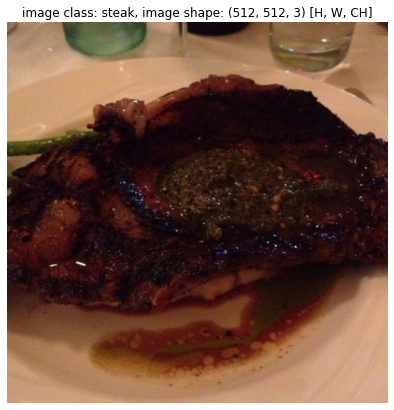

In [11]:
# visualize the data with matplotlib
import numpy as np
import matplotlib.pyplot as plt

# turn image to array
img_as_array = np.asarray(img)

# plot the image
plt.figure(figsize=(9,7))
plt.imshow(img_as_array)
plt.title(f"image class: {image_class}, image shape: {img_as_array.shape} [H, W, CH]")
plt.axis(False)

## Transforming data

Before we can use our image data with PyTorch:
1. turn your target data into tensors
2. turn it into a `torch.utils.data.Dataset` and subsequently a `torch.utils.data.DataLoader`

In [12]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

### Transforming data with `torchvision.transforms`

In [13]:
data_transform = transforms.Compose(
    [
      # resize our images to 64 x 64 -> to fit TinyVG Architecture 
      transforms.Resize(size=(64, 64)),
      # flip the images randomly on the horizontal 
      transforms.RandomHorizontalFlip(p=0.5),
      # turn image into tensor
      transforms.ToTensor()  
    ]
)

In [14]:
data_transform(img).shape

torch.Size([3, 64, 64])

In [15]:
data_transform(img).dtype

torch.float32

In [16]:
# plot the transformed images
def plot_transformed_images(
    image_paths: list,
    transform,
    n=3, # number of images
    seed=None):
  """
  Selects random images from a path of images and loads/transforms them
  then plots the original vs transformed
  """
  if seed:
    random.seed(seed)

  random_image_paths = random.sample(image_paths, k=n)

  for image_path in random_image_paths:
    with Image.open(image_path) as f:
      fig, ax = plt.subplots(nrows=1, ncols=2)
      print(fig)
      print(ax)
      ax[0].imshow(f)
      ax[0].set_title(f"original\nSize: {f.size}")
      ax[0].axis(False)

      # transformed and plot target image
      transformed_image = transform(f).permute(1, 2, 0) # change the shape for matplotlib from CHW -> HWC
      ax[1].imshow(transformed_image)
      ax[1].set_title(f"Transformed\nShape: {transformed_image.shape}")
      ax[1].axis("off")

      fig.suptitle(f"Class: {image_path.parent.stem}", fontsize=16)

Figure(432x288)
Figure(432x288)
Figure(432x288)


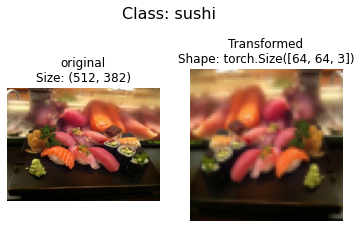

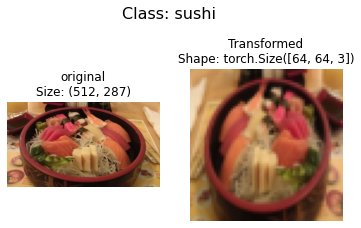

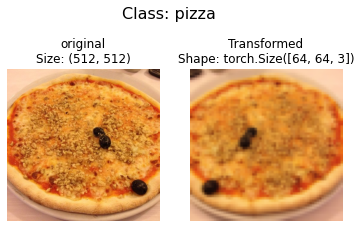

In [17]:
plot_transformed_images(
    image_paths=image_path_list,
    transform=data_transform,
    n=3,
    seed=42
)

## Option 1: Loading image data using `ImageFolder`

PyTorch `ImageFolder` Class: This class helps us to easily create PyTorch training and validation datasets without writing custom classes. Then we can use these datasets to create our iterable data loaders.

In [18]:
# use ImageFolder to create datasets
from torchvision import datasets

train_data = datasets.ImageFolder(root=train_dir,
                                  transform=data_transform,
                                  target_transform=None) # transform for a label 

test_data = datasets.ImageFolder(root=test_dir,
                                 transform=data_transform)

train_data, test_data

(Dataset ImageFolder
     Number of datapoints: 225
     Root location: data/pizza_steak_sushi/train
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=None)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ), Dataset ImageFolder
     Number of datapoints: 75
     Root location: data/pizza_steak_sushi/test
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=None)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ))

In [19]:
# get class names as list
class_names = train_data.classes
class_names

['pizza', 'steak', 'sushi']

In [20]:
# get class names as dict
class_dict = train_data.class_to_idx
class_dict

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [21]:
# check the lenghts
len(train_data), len(test_data)

(225, 75)

In [22]:
train_data

Dataset ImageFolder
    Number of datapoints: 225
    Root location: data/pizza_steak_sushi/train
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=None)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
           )

In [23]:
train_data[0]

(tensor([[[0.1176, 0.1216, 0.1255,  ..., 0.0980, 0.1020, 0.1137],
          [0.1294, 0.1294, 0.1294,  ..., 0.0980, 0.0980, 0.1059],
          [0.1333, 0.1333, 0.1333,  ..., 0.0941, 0.0980, 0.1020],
          ...,
          [0.1686, 0.1647, 0.1686,  ..., 0.1255, 0.1098, 0.1098],
          [0.1686, 0.1647, 0.1686,  ..., 0.1098, 0.0941, 0.0863],
          [0.1647, 0.1647, 0.1686,  ..., 0.0980, 0.0863, 0.0863]],
 
         [[0.0588, 0.0588, 0.0588,  ..., 0.0745, 0.0706, 0.0745],
          [0.0627, 0.0627, 0.0627,  ..., 0.0745, 0.0706, 0.0706],
          [0.0706, 0.0706, 0.0706,  ..., 0.0745, 0.0745, 0.0706],
          ...,
          [0.2392, 0.2392, 0.2510,  ..., 0.1373, 0.1333, 0.1255],
          [0.2314, 0.2392, 0.2510,  ..., 0.1255, 0.1176, 0.1098],
          [0.2275, 0.2353, 0.2431,  ..., 0.1137, 0.1059, 0.1020]],
 
         [[0.0196, 0.0196, 0.0196,  ..., 0.0902, 0.0902, 0.0941],
          [0.0196, 0.0157, 0.0196,  ..., 0.0902, 0.0863, 0.0902],
          [0.0196, 0.0157, 0.0157,  ...,

In [24]:
img, label = train_data[0][0], train_data[0][1]

In [25]:
print(f"Image tensor: {img}")

Image tensor: tensor([[[0.1176, 0.1216, 0.1255,  ..., 0.0980, 0.1020, 0.1137],
         [0.1294, 0.1294, 0.1294,  ..., 0.0980, 0.0980, 0.1059],
         [0.1333, 0.1333, 0.1333,  ..., 0.0941, 0.0980, 0.1020],
         ...,
         [0.1686, 0.1647, 0.1686,  ..., 0.1255, 0.1098, 0.1098],
         [0.1686, 0.1647, 0.1686,  ..., 0.1098, 0.0941, 0.0863],
         [0.1647, 0.1647, 0.1686,  ..., 0.0980, 0.0863, 0.0863]],

        [[0.0588, 0.0588, 0.0588,  ..., 0.0745, 0.0706, 0.0745],
         [0.0627, 0.0627, 0.0627,  ..., 0.0745, 0.0706, 0.0706],
         [0.0706, 0.0706, 0.0706,  ..., 0.0745, 0.0745, 0.0706],
         ...,
         [0.2392, 0.2392, 0.2510,  ..., 0.1373, 0.1333, 0.1255],
         [0.2314, 0.2392, 0.2510,  ..., 0.1255, 0.1176, 0.1098],
         [0.2275, 0.2353, 0.2431,  ..., 0.1137, 0.1059, 0.1020]],

        [[0.0196, 0.0196, 0.0196,  ..., 0.0902, 0.0902, 0.0941],
         [0.0196, 0.0157, 0.0196,  ..., 0.0902, 0.0863, 0.0902],
         [0.0196, 0.0157, 0.0157,  ..., 0.09

In [26]:
print(f" image label: {label}")

 image label: 0


In [27]:
class_names[label]

'pizza'

In [28]:
print(f"image shape: {img.shape}")

image shape: torch.Size([3, 64, 64])


In [29]:
print(f"image data type: {img.dtype}")

image data type: torch.float32


original image shape: torch.Size([3, 64, 64])
permuted image shape: torch.Size([64, 64, 3])


Text(0.5, 1.0, 'pizza')

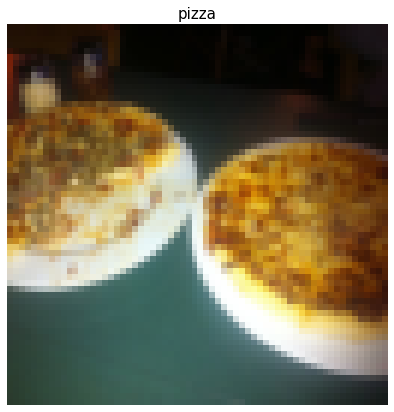

In [30]:
# let's visualize
# 1. rearrange the order dimensions
img_permute = img.permute(1, 2, 0)

# 2. print out diff shape
print(f"original image shape: {img.shape}") # [CHW]
print(f"permuted image shape: {img_permute.shape}") #[HWC]

# 3. plot the image
plt.figure(figsize=(10, 7))
plt.imshow(img_permute)
plt.axis("off")
plt.title(class_names[label], fontsize=15)

### Turn loaded images to `DataLoader`

It helps us to turn our datasets into iterable python (batches)

In [31]:
import os
os.cpu_count()

2

In [32]:
# turn train and test datasets into DataLoader's
from torch.utils.data import DataLoader

BATCH_SIZE = 1

train_dataloader = DataLoader(
    dataset=train_data,
    batch_size=BATCH_SIZE,
    num_workers=os.cpu_count(),
    shuffle=True
)

test_dataloader = DataLoader(
    dataset=test_data,
    batch_size=BATCH_SIZE,
    num_workers=os.cpu_count(),
    shuffle=False
)

train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x7f51b368c6a0>,
 <torch.utils.data.dataloader.DataLoader at 0x7f51b3681dc0>)

In [33]:
len(train_dataloader), len(test_dataloader)

(225, 75)

In [34]:
img, label = next(iter(train_dataloader))

print(f"Image shape: {img.shape} -> [batch_size, C, H, W]")
print(f"Label shape: {label.shape}")

Image shape: torch.Size([1, 3, 64, 64]) -> [batch_size, C, H, W]
Label shape: torch.Size([1])


## Opetion 2: Loading image data using custom `Dataset`

1. want to be able to load images from file
2. want to be able to get class names from the `Dataset`
3. want to be able to get classes as dictionary fro the `Dataset`

In [35]:
import os
import pathlib
import torch

from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms
from typing import Tuple, Dict, List

In [36]:
train_data.classes, train_data.class_to_idx

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

### Get class names by creating a helper function

we want to create a function:
1. get the class name using `os.scandir()` to navigate through the directory
2. rais an error if the class names aren't found
3. turn the class names into a dict, and list

In [37]:
# setup path for target directory
target_directory = train_dir
print(f"Target dir: {target_directory}")

Target dir: data/pizza_steak_sushi/train


In [38]:
# get the class names (as a list) from the target directory
class_names_found = sorted(entry.name for entry in list(os.scandir(target_directory)))
class_names_found

['pizza', 'steak', 'sushi']

In [39]:
def find_classes(directory: list) -> Tuple[List[str], Dict[str, int]]:
  """find the class folder names in a target directory."""
  # 1. get the class names by scanning the target directory
  classes = sorted(entry.name for entry in os.scandir(directory) if entry.is_dir())

  # 2. raise an error if class names could not be found
  if not classes:
    raise FileNotFoundError(f"couldn't find any classes in {directory} ... please check file structure.")

  # 3. create a dictionary of index labels
  class_to_index = {class_name: i for i, class_name in enumerate(classes)}

  return classes, class_to_index

In [40]:
find_classes(directory=target_directory)

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

### Create a custom `Dataset` to replicate `ImageFolder`

To create our own custom dataset, we want;

1. subclass `torch.utils.data.Dataset`
https://pytorch.org/docs/stable/data.html#torch.utils.data.Dataset
2. initialize a subclass with the target directory, as well as transform our data
3. create several attributes;
* paths - paths our images
* transform - the transform we would like to use
* class - a list of the target classes
* class_to_idx - a dict of the target classes mapped to integer labels
4. create a function to `load_images()` - this function will open an image
5. overwrite the `__len__()` method to return the length of our dataset
6. overwrite the `__getitem__()` method to return a given sample when passed an index 

In [41]:
# 0. write a custom dataset class
from torch.utils.data import Dataset

# 1. subclass torch.ultis.data.Dataset
class ImageFolderCustom(Dataset):
  # 2. initialize our custom dataset
  def __init__(self,
               targ_dir: str,
               transform=None):
    # 3. create class attributes
    # get all of the image paths
    self.paths = list(pathlib.Path(targ_dir).glob("*/*.jpg"))
    # setup a transform
    self.transform = transform
    # create classes and class_to_idx attributes
    self.classes, self.class_to_idx = find_classes(targ_dir)

  # 4. create a function to load images
  def load_image(self, index: int) -> Image.Image:
    """opens an image via a path and return it"""
    image_path = self.paths[index]
    return Image.open(image_path)

  # 5. overwrite __len__()
  def __len__(self) -> int:
    """returns the total number of samples"""
    return len(self.paths)

  # 6. overwrite __getitem__()
  def __getitem__(self, index: int) -> Tuple[torch.Tensor, int]:
    """returns one sample of data - data and label (X, y)"""
    img = self.load_image(index)
    class_name = self.paths[index].parent.name # expects path in format: data_folder/class_name/image.jpg
    class_idx = self.class_to_idx[class_name]

    # transform if necessary
    if self.transform:
      return self.transform(img), class_idx # returns data, label
    else:
      return img, class_idx # returns untransformed image and label

In [42]:
# create a transform
from torchvision import transforms

train_transform = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor()
])

test_transform = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    transforms.ToTensor()
])

In [43]:
# test out ImageFolderCustom

train_data_custom = ImageFolderCustom(targ_dir=train_dir,
                                      transform=train_transform)

test_data_custom = ImageFolderCustom(targ_dir=test_dir,
                                     transform=test_transform)

In [44]:
train_data_custom

In [45]:
len(train_data_custom) # from our own ImageFolderCustom class

225

In [46]:
len(train_data) # from pre-built ImageFolder class

225

In [47]:
train_data_custom.classes

['pizza', 'steak', 'sushi']

In [48]:
train_data_custom.class_to_idx

{'pizza': 0, 'steak': 1, 'sushi': 2}

### Create a function to display random images

1. take in a `Dataset` and a number of other parameters such as class names, and how many images to visualize
2. to prevent the display getting out of hand, let's cap the number of images to see at 10.
3. set the random seed for reproducibility
4. get a list of random sample indexes from the target dataset
5. setup a matplotlib
6. loop through the random sample images and plot them with matplotlib
7. make sure the dimensions of our images line up with matplotlib (HWC)

In [49]:
# 1. create a function to take in a dataset
def display_random_images(dataset: torch.utils.data.Dataset,
                          classes: List[str]=None,
                          n: int=10,
                          display_shape: bool=True,
                          seed: int=None):
  # 2. adjust display if n > 10
  if n > 10:
    n=10
    display_shape = False
    print(f"for display purpose, n should not be larger than 10, setting n to 10 and removing display shape.")

  # 3. set the seed
  if seed:
    random.seed(seed)

  # 4. get random sample indexes
  random_sample_idx = random.sample(range(len(dataset)), k=n)

  # 5. setup plot
  plt.figure(figsize=(16, 8))

  # 6. loop through random indexes and plot them with matplotlib
  for i, targ_sample in enumerate(random_sample_idx):
    targ_image, targ_label = dataset[targ_sample][0], dataset[targ_sample][1]

    # 7. adjust the dimension for matplotlib
    targ_image_adjust = targ_image.permute(1,2,0) # from CHW to HWC

    # 8. plot adjusted samples
    plt.subplot(1, n, i+1)
    plt.imshow(targ_image_adjust)
    plt.axis("off")
    if classes:
      title = f"Classes: {classes[targ_label]}"
      if display_shape:
        title = title + f"\nshape: {targ_image_adjust.shape}"
    plt.title(title)

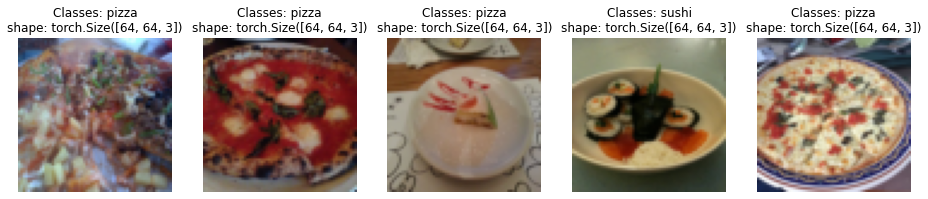

In [50]:
# display random images from the ImageFolder dataset
display_random_images(train_data,
                      n=5,
                      classes=class_names,
                      seed=None)

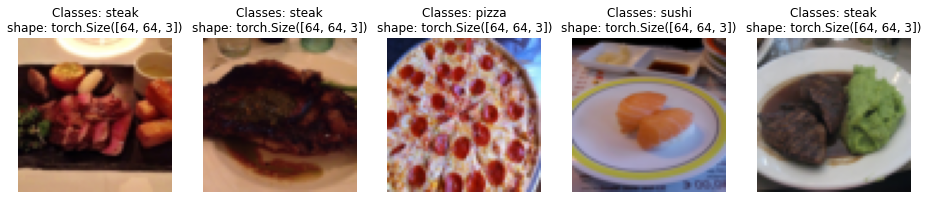

In [51]:
# display random images from ImageFolderCustom dataset
display_random_images(train_data_custom,
                      n=5,
                      classes=class_names,
                      seed=None)

### Turn custom loaded images into `DataLoader`

In [52]:
from torch.utils.data import DataLoader

BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()

train_dataloader_custom = DataLoader(
    dataset=train_data_custom,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
    shuffle=True
)

test_dataloader_custom = DataLoader(
    dataset=test_data_custom,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
    shuffle=False
)

train_dataloader_custom, test_dataloader_custom

(<torch.utils.data.dataloader.DataLoader at 0x7f51b2389d90>,
 <torch.utils.data.dataloader.DataLoader at 0x7f51b2389cd0>)

In [53]:
# get image and label from custom dataloader
img_custom, label_custom = next(iter(train_dataloader_custom))

# print out the shapes
img_custom.shape, label_custom.shape

(torch.Size([32, 3, 64, 64]), torch.Size([32]))

## Other forms of transforms (data augmentation)

Data augmentation is the process of artificially adding diversity to your training data.

In the case of image data, this may mean applying various image transformations to the training images.

This practice hopefully results in a model that's more generalizable to unseen data.

Let's take a look at one particular type of data augmentation used to train PyTorch vision models to state of the art levels -> TrivialAugment

In [54]:
from torchvision import transforms

train_transform = transforms.Compose(
    [
      transforms.Resize(size=(224,224)),
      transforms.TrivialAugmentWide(num_magnitude_bins=31),
      transforms.ToTensor()
    ]
)

test_transform = transforms.Compose(
    [
      transforms.Resize(size=(224,224)),
      transforms.ToTensor()  
    ]
)

In [55]:
# get all image paths
image_path_list = list(image_path.glob("*/*/*.jpg"))
image_path_list[:10]

[PosixPath('data/pizza_steak_sushi/train/sushi/1070104.jpg'),
 PosixPath('data/pizza_steak_sushi/train/sushi/1129338.jpg'),
 PosixPath('data/pizza_steak_sushi/train/sushi/1209865.jpg'),
 PosixPath('data/pizza_steak_sushi/train/sushi/3107839.jpg'),
 PosixPath('data/pizza_steak_sushi/train/sushi/497686.jpg'),
 PosixPath('data/pizza_steak_sushi/train/sushi/1214108.jpg'),
 PosixPath('data/pizza_steak_sushi/train/sushi/840444.jpg'),
 PosixPath('data/pizza_steak_sushi/train/sushi/148799.jpg'),
 PosixPath('data/pizza_steak_sushi/train/sushi/748830.jpg'),
 PosixPath('data/pizza_steak_sushi/train/sushi/170385.jpg')]

Figure(432x288)
Figure(432x288)
Figure(432x288)


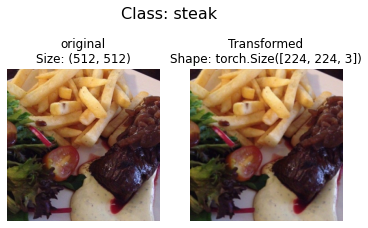

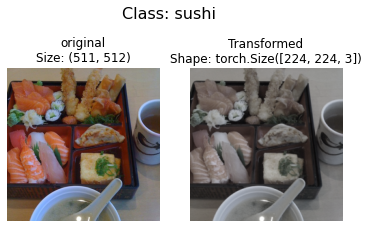

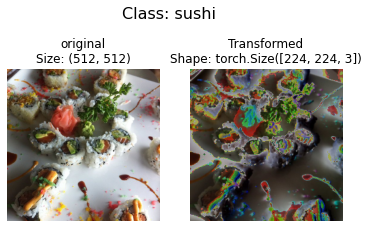

In [56]:
# plot random transformed images
plot_transformed_images(image_paths=image_path_list,
                        transform=train_transform,
                        n=3,
                        seed=None)

## Model 0: TinyVGG without data augmentation 

### Creating transforms and loading data for Model 0

In [57]:
# create simple transform

simple_transform = transforms.Compose(
    [
        transforms.Resize(size=(64, 64)),
        transforms.ToTensor()
    ]
)

In [58]:
# create training and testing dataset from ImageFolder class
from torchvision import datasets

train_data_simple = datasets.ImageFolder(
    root=train_dir,
    transform=simple_transform,
    target_transform=None
)

test_data_simple = datasets.ImageFolder(
    root=test_dir,
    transform=simple_transform
)

In [59]:
# load the data (batch-fy it)
from torch.utils.data import DataLoader
import os

BATCH_SIZE=32
NUM_WORKERS=os.cpu_count()

train_dataloader_simple = DataLoader(
    dataset=train_data_simple,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
    shuffle=True
)

test_dataloader_simple = DataLoader(
    dataset=test_data_simple,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
    shuffle=False
)

### Create TinyVGG model class

In [60]:
class TinyVGG(nn.Module):
  """Model Architecture copying TinyVGG"""
  def __init__(self,
               input_shape: int,
               hidden_units: int,
               output_shape: int) -> None:
    super().__init__()
    self.conv_block_1 = nn.Sequential(
        nn.Conv2d(in_channels=input_shape,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=0),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=0),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2,
                     stride=2) # default stride value is same as kernel size
    )
    self.conv_block_2 = nn.Sequential(
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=0),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=0),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2,
                     stride=2)
    )
    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=hidden_units*13*13,
                  out_features=output_shape)
    )

  def forward(self, x):
    x = self.conv_block_1(x)
    # print(x.shape)
    x = self.conv_block_2(x)
    # print(x.shape)
    x = self.classifier(x)
    # print(x.shape)
    return x
    # return self.classifier(self.conv_block_2(self.conv_block_1(x))) # good for GPU to benefit from operator fusion



> Note:
> **Operator fusion** is a way to improve performance by merging one operator (typically, an activation function) into a different operator so that they are executed together without requiring a roundtrip to memory.

In [61]:
torch.manual_seed(42)

model_0 = TinyVGG(input_shape=3, # number of color channels
                  hidden_units=10,
                  output_shape=len(class_names)).to(device) # number of classes

model_0

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1690, out_features=3, bias=True)
  )
)

### Try a forward pass on a single image - to test the model

In [62]:
# get a single image batch
image_batch, label_batch = next(iter(train_dataloader_simple))
image_batch.shape, label_batch.shape

(torch.Size([32, 3, 64, 64]), torch.Size([32]))

In [63]:
# try a forward pass
model_0(image_batch.to(device))

tensor([[ 2.0789e-02, -1.9351e-03,  9.5317e-03],
        [ 1.8427e-02,  2.4670e-03,  6.6757e-03],
        [ 1.7699e-02,  1.0262e-03,  9.4657e-03],
        [ 2.4441e-02, -3.3526e-03,  9.6011e-03],
        [ 1.9930e-02,  6.6316e-04,  1.0779e-02],
        [ 2.1281e-02,  2.0434e-03,  5.0046e-03],
        [ 2.0999e-02,  1.2869e-04,  1.2473e-02],
        [ 2.1577e-02, -1.9507e-03,  9.6941e-03],
        [ 2.4504e-02, -4.7745e-03,  8.5280e-03],
        [ 2.0252e-02, -4.7292e-04,  1.0908e-02],
        [ 2.2215e-02, -4.1837e-04,  9.8123e-03],
        [ 2.2313e-02, -2.1622e-03,  9.4456e-03],
        [ 2.1841e-02, -3.7132e-03,  8.3783e-03],
        [ 2.2863e-02, -1.7723e-03,  1.0287e-02],
        [ 2.1647e-02, -4.4139e-03,  9.5021e-03],
        [ 2.2096e-02, -4.1426e-03,  9.3853e-03],
        [ 2.1209e-02, -4.4218e-03,  1.1475e-02],
        [ 2.1711e-02, -2.7656e-03,  8.5006e-03],
        [ 1.9951e-02,  2.8272e-05,  8.4380e-03],
        [ 1.8298e-02,  1.6306e-03,  8.5499e-03],
        [ 2.0768e-02

### Use `torchinfo` to get an idea of the shapes going through our model

In [64]:
!pip install torchinfo

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [65]:
import torchinfo
from torchinfo import summary

summary(model_0, input_size=(1, 3, 64, 64))

Layer (type:depth-idx)                   Output Shape              Param #
TinyVGG                                  [1, 3]                    --
├─Sequential: 1-1                        [1, 10, 30, 30]           --
│    └─Conv2d: 2-1                       [1, 10, 62, 62]           280
│    └─ReLU: 2-2                         [1, 10, 62, 62]           --
│    └─Conv2d: 2-3                       [1, 10, 60, 60]           910
│    └─ReLU: 2-4                         [1, 10, 60, 60]           --
│    └─MaxPool2d: 2-5                    [1, 10, 30, 30]           --
├─Sequential: 1-2                        [1, 10, 13, 13]           --
│    └─Conv2d: 2-6                       [1, 10, 28, 28]           910
│    └─ReLU: 2-7                         [1, 10, 28, 28]           --
│    └─Conv2d: 2-8                       [1, 10, 26, 26]           910
│    └─ReLU: 2-9                         [1, 10, 26, 26]           --
│    └─MaxPool2d: 2-10                   [1, 10, 13, 13]           --
├─Sequentia

### Creating train and test loops functions

* `train_step()` - takes in a model and dataloader and trains the model on the dataloader
* `test_step()` - takes in a model and dataloader and evaluates the model on the dataloader

In [66]:
# Create train_step()
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer:torch.optim.Optimizer,
               device=device):
  # Put the model in train mode
  model.train()

  # Setup train loss and train accuracy values
  train_loss, train_acc = 0, 0

  # Loop through data loader data batches
  for batch, (X, y) in enumerate(dataloader):
    # Send data to the target device
    X, y = X.to(device), y.to(device)

    # 1. Forward pass
    y_pred = model(X) # output model logits

    # 2. Calculate the loss
    loss = loss_fn(y_pred, y)
    train_loss += loss.item()

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backward
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    # Calculate accuracy metric
    y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
    train_acc += (y_pred_class==y).sum().item()/len(y_pred)
  
  # Adjust metrics to get average loss and accuracy per batch
  train_loss = train_loss / len(dataloader)
  train_acc = train_acc / len(dataloader) 
  return train_loss, train_acc 

In [67]:
# Create a test step
def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              device=device):
  # Put model in eval mode
  model.eval()

  # Setup test loss and test accuracy values
  test_loss, test_acc = 0,  0

  # Turn on inference mode
  with torch.inference_mode():
    # Loop through DataLoader batches
    for batch, (X, y) in enumerate(dataloader): 
      # Send data to the target device
      X, y = X.to(device), y.to(device)

      # 1. Forward pass
      test_pred_logits = model(X)

      # 2. Calculate the loss
      loss = loss_fn(test_pred_logits, y)
      test_loss += loss.item()

      # Calculate the accuracy
      test_pred_labels = test_pred_logits.argmax(dim=1)
      test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))

  # Adjust metrics to get average loss and accuracy per batch
  test_loss = test_loss / len(dataloader)
  test_acc = test_acc / len(dataloader)
  return test_loss, test_acc

### creating a `train()` function to combine training loop and testing loop functions

In [68]:
from tqdm.auto import tqdm
from torch import nn

def train(model,
          train_dataloader,
          optimizer,
          test_dataloader,
          epochs=5,
          device=device,
          loss_fn=nn.CrossEntropyLoss()):
  
  # create empty results dictionary
  results = {"train_loss": [],
             "train_acc": [],
             "test_loss": [],
             "test_acc": []}
  
  # loop through training and testing steps for a number of epochs
  for epoch in tqdm(range(epochs)):
    train_loss, train_acc = train_step(model=model,
                                       dataloader=train_dataloader,
                                       loss_fn=loss_fn,
                                       optimizer=optimizer,
                                       device=device)
    test_loss, test_acc = test_step(model=model,
                                    dataloader=test_dataloader,
                                    loss_fn=loss_fn,
                                    device=device)
    
    # print out what's happening
    print(f"Epoch: {epoch}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}%, Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}%")

    # update results dictionary
    results["train_loss"].append(train_loss)
    results["train_acc"].append(train_acc)
    results["test_loss"].append(test_loss)
    results["test_acc"].append(test_acc)

  return results

### Train and evaluate model 0

In [69]:
from torch import nn
# set the random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# set the number of epochs
EPOCHS = 7

# create an instance of TinyVGG
model_0 = TinyVGG(input_shape=3,
                  hidden_units=10,
                  output_shape=len(train_data.classes)).to(device)

# setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_0.parameters(), lr=0.001)

# start the timer
from timeit import default_timer as timer
start_timer = timer()

# train model 0
model_0_results = train(model=model_0,
                        train_dataloader=train_dataloader_simple,
                        test_dataloader=test_dataloader_simple,
                        optimizer=optimizer,
                        loss_fn=loss_fn,
                        epochs=EPOCHS,
                        device=device)

# end the timer
end_timer = timer()

print(f"total training timer: {end_timer - start_timer:.3f} seconds")

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch: 0, Train Loss: 1.1063, Train Acc: 0.3047%, Test Loss: 1.0983, Test Acc: 0.3116%
Epoch: 1, Train Loss: 1.0995, Train Acc: 0.3320%, Test Loss: 1.0699, Test Acc: 0.5417%
Epoch: 2, Train Loss: 1.0863, Train Acc: 0.4922%, Test Loss: 1.0800, Test Acc: 0.5227%
Epoch: 3, Train Loss: 1.0826, Train Acc: 0.4102%, Test Loss: 1.0599, Test Acc: 0.5729%
Epoch: 4, Train Loss: 1.0630, Train Acc: 0.4141%, Test Loss: 1.0609, Test Acc: 0.5540%
Epoch: 5, Train Loss: 1.0212, Train Acc: 0.4609%, Test Loss: 1.0064, Test Acc: 0.4820%
Epoch: 6, Train Loss: 0.9662, Train Acc: 0.4297%, Test Loss: 0.9272, Test Acc: 0.6042%
total training timer: 11.363 seconds


### Plot the loss curve of Model 0

A loss curve is a way of tracking your model's progress over time.

In [70]:
model_0_results.keys()

dict_keys(['train_loss', 'train_acc', 'test_loss', 'test_acc'])

In [71]:
def plot_loss_curves(results: Dict[str, List[float]]):
  """plot training curves of a result dictionary."""

  # get the loss values of the results dictionary (training, and test)
  loss = results["train_loss"]
  test_loss = results["test_loss"]

  # get the accuracy of the results dictionary (training, and test)
  accuracy = results["train_acc"]
  test_accuracy = results["test_acc"]

  # figure out how many epochs there were
  epochs = range(len(results["train_loss"]))

  # setup a plot
  plt.figure(figsize=(15, 7))

  # plot the loss
  plt.subplot(1,2,1) # row=1, col=2, index=1
  plt.plot(epochs, loss, label="train_loss")
  plt.plot(epochs, test_loss, label="test_loss")
  plt.title("Loss")
  plt.xlabel("Epochs")
  plt.legend()

  # plot the accuracy
  plt.subplot(1,2,2)
  plt.plot(epochs, accuracy, label="train_accuracy")
  plt.plot(epochs, test_accuracy, label="test_accuracy")
  plt.title("Accuracy")
  plt.xlabel("Epochs")
  plt.legend()

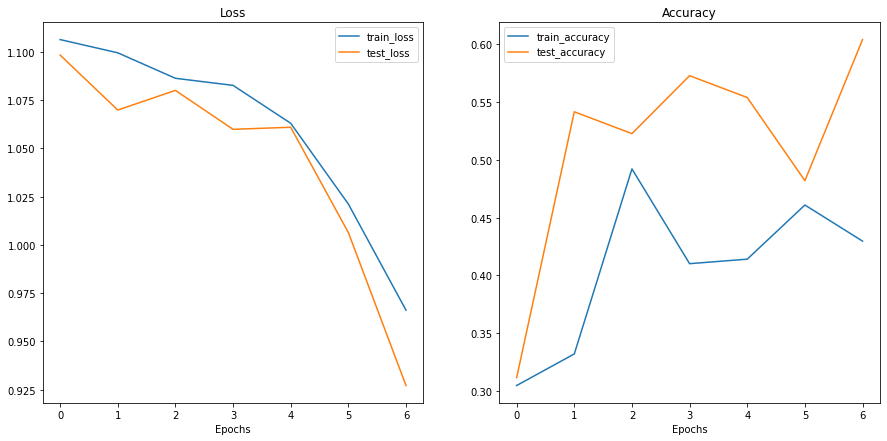

In [72]:
plot_loss_curves(model_0_results)

## Model 1: TinyVGG with Data Augmentation

### Create transform with data augmentation


In [73]:
from torchvision import transforms

train_transform_trivial = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    transforms.TrivialAugmentWide(num_magnitude_bins=31), # 31 means high intensity
    transforms.ToTensor()
])

# no need for data augmentation in the testing data
test_transform_simple = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    transforms.ToTensor()
])

### Create train and test `Dataset`'s and `DataLoader`'s with data augmentation

In [74]:
# turn image folders into Dataset
from torchvision import datasets

train_data_augmented = datasets.ImageFolder(
    root=train_dir,
    transform=train_transform_trivial
)

test_data_simple = datasets.ImageFolder(
    root=test_dir,
    transform=test_transform_simple
)

In [75]:
# turn our Datasets into DataLoaders
import os
from torch.utils.data import DataLoader

BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()

torch.manual_seed(42)
train_dataloader_augmented = DataLoader(
    dataset=train_data_augmented,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS
)

test_dataloader_simple = DataLoader(
    dataset=test_data_simple,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
    shuffle=False
)

### Construct and train model 1

In [76]:
# create model 1 and send it to the target device
torch.manual_seed(42)
model_1 = TinyVGG(input_shape=3,
                  hidden_units=10,
                  output_shape=len(train_data_augmented.classes)).to(device)

model_1

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1690, out_features=3, bias=True)
  )
)

In [77]:
# let's create a loss function and optimizer

torch.manual_seed(42)
torch.cuda.manual_seed(42)

NUM_EPOCHS = 7

# setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_1.parameters(), lr=0.001)

# start the timer
from timeit import default_timer as timer
start_timer = timer()

# train model 1
model_1_results = train(
    model=model_1,
    train_dataloader=train_dataloader_augmented,
    test_dataloader=test_dataloader_simple,
    loss_fn=loss_fn,
    optimizer=optimizer,
    epochs=NUM_EPOCHS,
    device=device
)

# end the timer
end_timer = timer()

print(f"total training time for model 1: {end_timer - start_timer:.3f} seconds")

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch: 0, Train Loss: 1.1049, Train Acc: 0.2500%, Test Loss: 1.1019, Test Acc: 0.2604%
Epoch: 1, Train Loss: 1.0807, Train Acc: 0.4258%, Test Loss: 1.1260, Test Acc: 0.2604%
Epoch: 2, Train Loss: 1.0711, Train Acc: 0.4258%, Test Loss: 1.1587, Test Acc: 0.2604%
Epoch: 3, Train Loss: 1.1251, Train Acc: 0.3047%, Test Loss: 1.1585, Test Acc: 0.2604%
Epoch: 4, Train Loss: 1.0849, Train Acc: 0.4258%, Test Loss: 1.1555, Test Acc: 0.3229%
Epoch: 5, Train Loss: 1.0868, Train Acc: 0.3789%, Test Loss: 1.1438, Test Acc: 0.2708%
Epoch: 6, Train Loss: 1.0730, Train Acc: 0.4922%, Test Loss: 1.1354, Test Acc: 0.3333%
total training time for model 1: 10.775 seconds


### Plot the loss curve for model 1

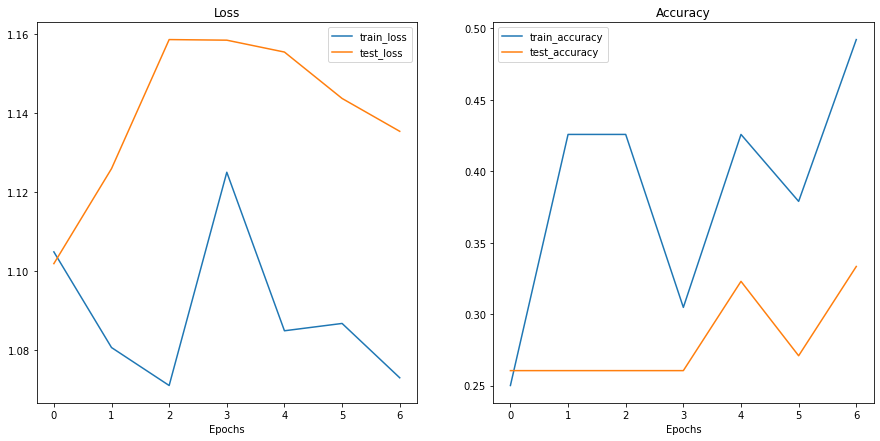

In [78]:
plot_loss_curves(
    results=model_1_results
)

## Compare model results

After evaluating our modelling experiments on their own, it's important to compare them to each other.

There's a few different ways to do this:

1. Hard coding (what we are doing)
2. PyTorch + Tensorboard
3. Weights & Bias
4. MLFlow

In [79]:
import pandas as pd

model_0_df = pd.DataFrame(model_0_results)
model_1_df = pd.DataFrame(model_1_results)

model_0_df

,train_loss,train_acc,test_loss,test_acc
0,1.106342,0.304688,1.098314,0.311553
1,1.099484,0.332031,1.069852,0.541667
2,1.086289,0.492188,1.080026,0.522727
3,1.082625,0.410156,1.059859,0.572917
4,1.062995,0.414062,1.060932,0.553977
5,1.021175,0.460938,1.006419,0.482008
6,0.966192,0.429688,0.927172,0.604167


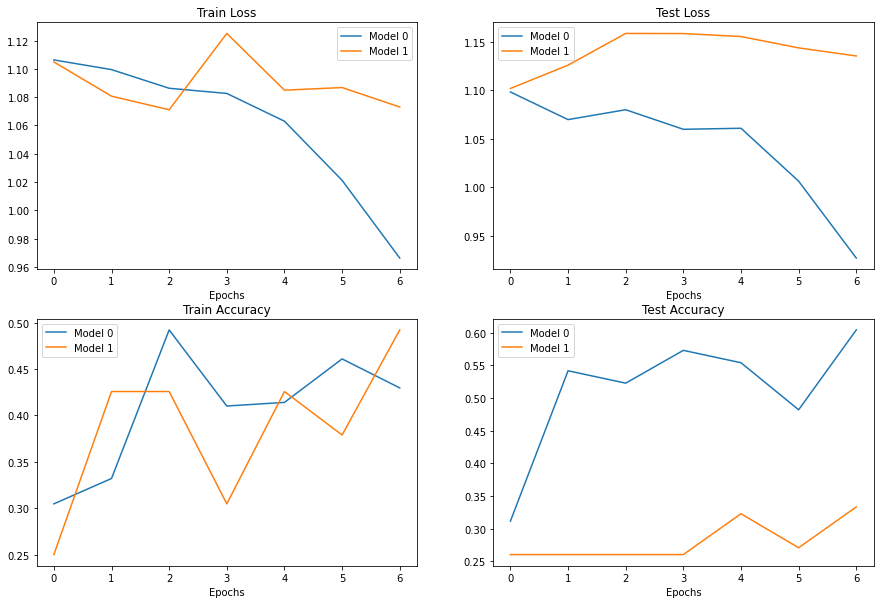

In [80]:
# setup a plot
plt.figure(figsize=(15, 10))

# get the number of epochs
epochs = range(len(model_1_df))

# plot train loss
plt.subplot(2, 2, 1)
plt.plot(epochs, model_0_df["train_loss"], label="Model 0")
plt.plot(epochs, model_1_df["train_loss"], label="Model 1")
plt.title("Train Loss")
plt.xlabel("Epochs")
plt.legend()

# plot test loss
plt.subplot(2, 2, 2)
plt.plot(epochs, model_0_df["test_loss"], label="Model 0")
plt.plot(epochs, model_1_df["test_loss"], label="Model 1")
plt.title("Test Loss")
plt.xlabel("Epochs")
plt.legend()

# plot train acc
plt.subplot(2, 2, 3)
plt.plot(epochs, model_0_df["train_acc"], label="Model 0")
plt.plot(epochs, model_1_df["train_acc"], label="Model 1")
plt.title("Train Accuracy")
plt.xlabel("Epochs")
plt.legend()

# plot test loss
plt.subplot(2, 2, 4)
plt.plot(epochs, model_0_df["test_acc"], label="Model 0")
plt.plot(epochs, model_1_df["test_acc"], label="Model 1")
plt.title("Test Accuracy")
plt.xlabel("Epochs")
plt.legend()

## Making a prediction on a custom image

In [81]:
data_path

PosixPath('data')

In [82]:
# download custom image
import requests

# setup custom image path
custom_image_path = data_path / "steak_image.jpg"

# download the image if it doesn't already exist
if not custom_image_path.is_file():
  with open(custom_image_path, "wb") as f:
    request = requests.get("https://raw.githubusercontent.com/moabdelmoez/learn_pytorch/main/steak_image.jpg")
    print(f"Downloading {custom_image_path} ...")
    f.write(request.content)

else:
  print(f"{custom_image_path} already exists :-)")

### Loading in a custom image with PyTorch

We have to make sure our custom image is in the same format as the data our model was trained on.

* In tensor form with datatype(torch.float32)
* Of shape 64 x 64 x 3
* On the right device

In our case we need to read an image in the PyTorch format - thankfully we have in-built function to do so.

https://pytorch.org/vision/stable/generated/torchvision.io.read_image.html#torchvision.io.read_image

In [83]:
import torchvision

# read in custom image
custom_image_uint = torchvision.io.read_image(str(custom_image_path))

custom_image_uint

tensor([[[180, 177, 177,  ..., 145, 144, 143],
         [179, 176, 176,  ..., 146, 146, 145],
         [181, 179, 179,  ..., 143, 142, 141],
         ...,
         [225, 223, 223,  ..., 218, 218, 217],
         [226, 224, 223,  ..., 216, 216, 217],
         [226, 224, 223,  ..., 215, 215, 218]],

        [[193, 190, 190,  ..., 131, 130, 129],
         [192, 189, 189,  ..., 132, 132, 131],
         [194, 192, 192,  ..., 129, 128, 127],
         ...,
         [238, 236, 236,  ..., 232, 232, 231],
         [239, 237, 236,  ..., 233, 233, 234],
         [239, 237, 236,  ..., 232, 232, 235]],

        [[209, 206, 206,  ..., 130, 129, 128],
         [208, 205, 205,  ..., 131, 131, 130],
         [210, 208, 208,  ..., 128, 127, 126],
         ...,
         [246, 244, 244,  ..., 241, 241, 240],
         [247, 245, 244,  ..., 241, 241, 242],
         [247, 245, 244,  ..., 240, 240, 243]]], dtype=torch.uint8)

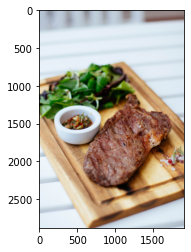

In [84]:
# plot the image
plt.imshow(custom_image_uint.permute(1, 2, 0))

In [85]:
print(f"Custom image shape:\n {custom_image_uint.shape}")
print(f"Custom image data type:\n {custom_image_uint.dtype}")

Custom image shape:
 torch.Size([3, 2880, 1920])
Custom image data type:
 torch.uint8


### Making a prediction on a custom image with a trained PyTorch model

In [86]:
# try to make prediction on an image in uint8 format
model_1.eval()
with torch.inference_mode():
  model_1(custom_image_uint.to(device))

RuntimeError: ignored

In [87]:
# load in the custom image and convert to torch.float32
# and also we need to scale the image to be between 0, and 1 -> that's by divide it by 255 
custom_image = torchvision.io.read_image(str(custom_image_path)).type(torch.float32) / 255.
custom_image

tensor([[[0.7059, 0.6941, 0.6941,  ..., 0.5686, 0.5647, 0.5608],
         [0.7020, 0.6902, 0.6902,  ..., 0.5725, 0.5725, 0.5686],
         [0.7098, 0.7020, 0.7020,  ..., 0.5608, 0.5569, 0.5529],
         ...,
         [0.8824, 0.8745, 0.8745,  ..., 0.8549, 0.8549, 0.8510],
         [0.8863, 0.8784, 0.8745,  ..., 0.8471, 0.8471, 0.8510],
         [0.8863, 0.8784, 0.8745,  ..., 0.8431, 0.8431, 0.8549]],

        [[0.7569, 0.7451, 0.7451,  ..., 0.5137, 0.5098, 0.5059],
         [0.7529, 0.7412, 0.7412,  ..., 0.5176, 0.5176, 0.5137],
         [0.7608, 0.7529, 0.7529,  ..., 0.5059, 0.5020, 0.4980],
         ...,
         [0.9333, 0.9255, 0.9255,  ..., 0.9098, 0.9098, 0.9059],
         [0.9373, 0.9294, 0.9255,  ..., 0.9137, 0.9137, 0.9176],
         [0.9373, 0.9294, 0.9255,  ..., 0.9098, 0.9098, 0.9216]],

        [[0.8196, 0.8078, 0.8078,  ..., 0.5098, 0.5059, 0.5020],
         [0.8157, 0.8039, 0.8039,  ..., 0.5137, 0.5137, 0.5098],
         [0.8235, 0.8157, 0.8157,  ..., 0.5020, 0.4980, 0.

In [88]:
custom_image.shape

torch.Size([3, 2880, 1920])

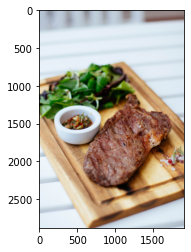

In [89]:
plt.imshow(custom_image.permute(1, 2, 0))

In [90]:
model_1.eval()
with torch.inference_mode():
  model_1(custom_image.to(device))

RuntimeError: ignored

In [91]:
# create transform pipeline to resize image
from torchvision import transforms
custom_image_transform = transforms.Compose([
    transforms.Resize(size=(64, 64))
])

# transform target image
custom_image_transformed = custom_image_transform(custom_image)

# print out the shape
print(f"Transformed Image Shape: {custom_image_transformed.shape}")

Transformed Image Shape: torch.Size([3, 64, 64])


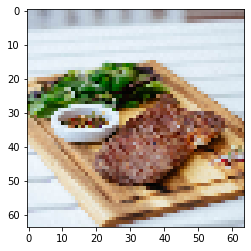

In [92]:
plt.imshow(custom_image_transformed.permute(1, 2, 0)) # pixalized image (what the model sees)

In [93]:
# this error because no batch size
model_1.eval()
with torch.inference_mode():
  model_1(custom_image_transformed.to(device))

RuntimeError: ignored

In [94]:
model_1.eval()
with torch.inference_mode():
  custom_pred = model_1(custom_image_transformed.unsqueeze(0).to(device))
custom_pred

tensor([[ 0.0803,  0.0042, -0.2006]], device='cuda:0')

In [95]:
# convert logits -> pred probabilities
custom_pred_probs = torch.softmax(custom_pred, dim=1)
custom_pred_probs

tensor([[0.3729, 0.3456, 0.2816]], device='cuda:0')

In [96]:
# convert pred probs -> pred labels
custom_pred_label = torch.argmax(custom_pred_probs, dim=1).cpu()
custom_pred_label

tensor([0])

In [97]:
class_names[custom_pred_label]

# wrong prediction :-( 

'pizza'

### Putting custom image prediction together: building a function

* input: image path, and a model
* output: plot the image and predict the label

In [118]:
def pred_and_plot_image(model: torch.nn.Module,
                        image_path: str,
                        class_names: List[str] = None,
                        transform = None,
                        device=device):
  """
  Make a prediction on a target image with a trained model, and plot the image and prediction
  """

  # load in the image
  target_image = torchvision.io.read_image(str(image_path)).type(torch.float32)

  # scale the image between [0, 1] by dividing by 255.
  target_image /= 255.

  # transform if necessary
  if transform:
    target_image = transform(target_image)

  # make sure the model in on the target device
  model.to(device)

  # turn on eval/inference mode and make prediction
  model.eval()
  with torch.inference_mode():
    # add an extra dimension (this is the batch dimension)
    target_image = target_image.unsqueeze(dim=0)

    # make a prediction
    target_image_pred = model(target_image.to(device))
  
  # convert logits -> pred probs
  target_image_pred_probs = torch.softmax(target_image_pred, dim=1)
  # convert pred probs -> pred label
  target_image_pred_label = torch.argmax(target_image_pred_probs, dim=1)

  # plot the image
  plt.imshow(target_image.squeeze().permute(1, 2, 0)) # remove batch dimension and rearrange the shape
  if class_names:
    title = f"Pred: {class_names[target_image_pred_label.cpu()]}, Prob: {target_image_pred_probs.max().cpu():.3f}"
  else:
    title = f"Pred: {target_image_pred_label.cpu()}, Prob: {target_image_pred_probs.max().cpu():3f}"

  plt.title(title)
  plt.axis("off")

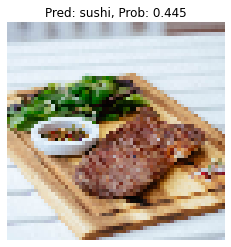

In [119]:
pred_and_plot_image(model=model_0,
                    image_path=custom_image_path,
                    class_names=class_names,
                    transform=custom_image_transform,
                    device=device)